In [1]:
import numpy as np
import sys
import time
import os
import h5py
import os.path as op
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from multiprocessing import Pool
from itertools import product
from par_funcs import *
%matplotlib inline
sys.path.append('..')
cmap = matplotlib.colors.ListedColormap(np.vstack( ((0, 0, 0), np.random.rand(1e6, 3))) )
V = 20

# -------------------------------- parameters ---------------------------------------
# pred_file = '/groups/turaga/home/turagas/research/caffe_v2/processed/bock2/120000/sample_A_x1_y1_z1_xy1.h5'
pred_file = '/groups/turaga/home/turagas/research/caffe_v2/processed/bock2/120000/cutout_3k.h5'
# pred_file = '/groups/turaga/home/turagas/turagalab/FROM_TIER2/singhc/train/output_200000/tstvol-1_2.h5'
out_folder = '/nobackup/turaga/singhc/par_zwshed/' # _3k _vol has full, max_len = 300
outname = out_folder+'out.h5'
NUM_WORKERS = 32
MAX_LEN = 100

/groups/turaga/home/singhc/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


# Partition

In [4]:
partition_data = partition_subvols(pred_file,out_folder,max_len=MAX_LEN)

dims [ 200 3072 3072]
num_vols [ 3 31 31]
deltas [66 99 99]


# Call Watershed

In [5]:
eval_with_par_map(partition_data[0][0:2],NUM_WORKERS)

finished /nobackup/turaga/singhc/par_zwshed/0_0_0_vol/ watershed
finished /nobackup/turaga/singhc/par_zwshed/0_0_96_vol/ watershed


# Stitch

i,x,y,z 0 0 0 0
i,x,y,z 1 0 0 1
filter_merges...


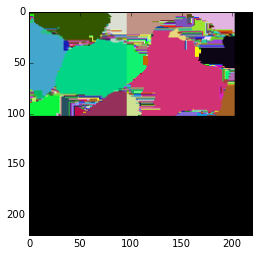

merge


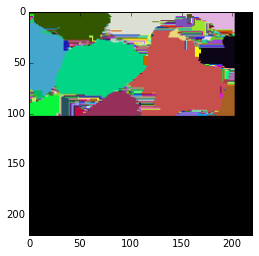

calculating seg_sizes all...


In [8]:
stitch_and_save(partition_data,outname)

# Agglomeration

In [ ]:
num,thresh = 0,2000

'''
plt.subplot(1,2,1)
basic_file = h5py.File('/nobackup/turaga/singhc/par_zwshed/0_0_0_voll/'+'basic.h5','r')
seg_init = np.array(basic_file['seg'])
rg_init = np.array(basic_file['rg'])
keeps = rg_init[:,0]<rg_init[:,1]
rg_init = rg_init[keeps,:]

seg_sizes_init = np.array(basic_file['counts'])
basic_file.close()
plt.imshow(seg_init[V,:,:], cmap=cmap)
plt.title('seg_init')
'''

plt.subplot(1,2,2)
f = h5py.File(outname, 'a')
s,e = f['starts'][num],f['ends'][num]
seg = f['seg'][s[0]:e[0]-3,s[1]:e[1]-3,s[2]:e[2]-3]
seg_sizes = np.array(f['seg_sizes'])
rg = np.array(f['rg_'+str(num)])
f.close()
plt.imshow(seg[V,:,:], cmap=cmap)
plt.title('seg_after_stitching')
plt.show()

print "num_segs",len(np.unique(seg_init)),len(np.unique(seg))
print "rg lens",len(rg_init),len(rg)


# seg_init_merged = merge_by_thresh(seg_init,seg_sizes_init,rg_init,thresh)
seg_merged = merge_by_thresh(seg,seg_sizes,rg,thresh)

plt.subplot(1,2,1)
plt.imshow(seg_init_merged[V,:,:], cmap=cmap)
plt.title('merged init')
plt.subplot(1,2,2)
plt.imshow(seg_merged[V,:,:], cmap=cmap)
plt.title('merged')
plt.show()

print "num_segs",len(np.unique(seg_init)),len(np.unique(seg))
print "rg lens",len(rg_init),len(rg)

# Visualize

In [ ]:
import nyroglancer

seg = np.arange(0,10000)
seg = np.reshape(seg,(100,100))
seg = np.array(seg,dtype='uint32')

v = nyroglancer.Viewer()
v.set_hostname("localhost:8000")
v.put(seg, resolution=[1,1,1], vtype="segmentation", name="raw")
v.show()